# Example: Heavy-fluxonium initialization procedure

B. McDonough

This notebook provides a tutorial for using scQubits to simulate the heavy-fluxonium initialization procedure described in [Universal fast flux control of a coherent, low-frequency qubit](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011010) by Zhang et al.

For a typical heavy-fluxonium qubit, the frequency of the transition between the first two energy levels is small in comparison to the temperature of the bath. Thus the qubit relaxes to a mixed state, in contrast to higher-frequency transmon qubits which typically relax to the ground state. The coupling to a low-Q resonator provides the nonunitary evolution needed to remove entropy from this state.

To summarize this procedure, the qubit begins in a nearly completely mixed state between the first two energy levels, $\rho \approx \frac{1}{2}(|g\rangle \langle g| +|e\rangle \langle e|)\otimes |0\rangle \langle 0 |$. The first four levels of the fluxonium are labeled with $g,e,f,h$ respectively, and the resonator Fock states are labeled with numbers. The transitions $|g0\rangle$ to $|h0\rangle$ and $|h0\rangle$ to $|e1\rangle$ are driven simulataneously for a period of 15 $\mu$ s. Throughout this process, photon loss in the resonator causes the population of $|e1\rangle$ to transition to $|e0\rangle$. The system eventually reaches a steady state, preparing $|e0\rangle$ with high fidelity.

The Hamiltonian of the coupled fluxonium-resonator system with a drive at feequency $\omega_d$ capacitively coupled to the resonator is
$$
H = 8\pi E_C\hat n - 2\pi E_J \cos(\hat \phi-\pi) + \pi E_L \hat \phi^2 + 2\pi g \hat n (a+a^\dagger) + 2\pi E_{osc}a^\dagger a + f(t)\cos(\omega_d t)(a+a^\dagger)
$$

In [35]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt

#experimental values borrowed from 
# https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011010
qbt = scq.Fluxonium(
    EJ = 3.395,
    EC = .479,
    EL = .132,
    flux = .5, #flux frustration point
    cutoff = 110,
    truncated_dim = 10
)

osc = scq.Oscillator(
    E_osc=5.7,
    truncated_dim=8,
    id_str = 'resonator'
)

hilbertspace = scq.HilbertSpace([qbt, osc])

hilbertspace.add_interaction(
    g_strength = .4,
    op1 = qbt.n_operator,
    op2 = osc.creation_operator,
    add_hc = True
)

#Precompute eigensystem to save later computation
hilbertspace.generate_lookup()

## Drive simulation functions

In [36]:
#get the index of a dressed state closed to a subsystem product state
def dressed_index(hilbertspace, *states):
    states_by_index = list(sorted([(hilbertspace.get_subsys_index(sys), state) for (sys, state) in states]))
    return hilbertspace.dressed_index(list(zip(*states_by_index))[1])[0]

def basis_change(operator, subsystem, hilbertspace, dressed_eigenbasis = True):
    """This method can be used to express a subsystem operator in the dressed energy eigenbasis
    of the full hilbertspace, expecially useful for simulations in QuTiP.

    Args:
        operator (Qobj): A subsystem operator with dimension cutoff x cutoff
        subsystem (Qubit or Resonator): The subsystem acted on by the operator
        hilbertspace (HilbertSpace): The Hilbert space representing the composite system

    Returns:
        (Qobj): An operator with the same dimension as the HilbertSpace
    """

    #Get bare eigenvectors of subsystem stored in hilbertspace
    bare_evecs, = hilbertspace.bare_eigenstates(subsystem)
    #Express operator in bare eigenbasis and tensor with appropriate identities
    op_id_wrap = scq.identity_wrap(operator, subsystem, hilbertspace.subsys_list, evecs = bare_evecs)
    #Get full dressed eigenbasis
    evecs, = hilbertspace["evecs"]
    return op_id_wrap.transform(evecs)

#truncate operators to desdired dimension
def truncate(operator, dimension):
    return qt.Qobj(operator[:dimension, : dimension])

#get the transition frequency between two states specified by dressed indices
def transition_frequency(s0, s1):
    return (hilbertspace.energy_by_dressed_index(s1)-hilbertspace.energy_by_dressed_index(s0))*2*np.pi

#Get the period of one Rabi cycle as a function of operator matrix element and drive strength
def drive_strength(s0, s1, period, drive_operator):
    #divide by 2pi for drive strength in units of GHz
    return abs(1/(period*drive_operator.data.toarray()[s0][s1]))

def rabi_period(s0, s1, Omega, drive_operator):
    #divide by 2pi for period in units of ns
    return abs(1/(Omega*drive_operator.data.toarray()[s0][s1]))

## Drive operators

In [5]:
#The matrix representations can be truncated further for the simulation
total_truncation = 20

#resonator drive operator
phi_r = basis_change(osc.annihilation_operator()+osc.creation_operator(), osc, hilbertspace)
phi_r_trunc = truncate(phi_r, total_truncation)

#qubit charge operator
n_qbt = basis_change(qbt.n_operator(), qbt, hilbertspace)
n_qbt_trunc = truncate(n_qbt, total_truncation)

The dressed eigenstates correspond closely to the bare product states when the coupling is weak. The `dressed_index` function matches a product state to the corresponding dressed eigenstate.

In [6]:
g0 = dressed_index(hilbertspace, (qbt, 0 ),(osc, 0))
e0 = dressed_index(hilbertspace, (qbt, 1), (osc, 0))
h0 = dressed_index(hilbertspace, (qbt, 3), (osc, 0))
e1 = dressed_index(hilbertspace, (qbt, 1), (osc, 1))

#Get eigenstates matching product state dressed indices
states = [qt.basis(total_truncation,i) for i in [g0,e0,h0,e1]]

In [27]:
sim_period = 500
Omega1 = drive_strength(g0, h0, sim_period, phi_r)
Omega2 = drive_strength(h0, e1, sim_period, phi_r)

#g0 -> h0 transition
omega_1 = transition_frequency(h0, g0)
#h0 -> e1 transition
omega_2 = transition_frequency(e1, h0)

#drive amplitude as a function of time
def drive_coeff(t, args):
    return Omega1*np.cos(omega_1*t) + Omega2*np.cos(omega_2*t)

#get the diagonal Hamiltonan in the dressed basis and truncate to the desired level
evals, = hilbertspace["evals"]
#The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = qt.Qobj(2*np.pi*np.diag(evals), dims = [hilbertspace.subsystem_dims]*2)
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

#The time-dependent driven Hamiltonian
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2*np.pi*phi_r_trunc, drive_coeff] #driving through the resonator
]

## Resonator photon loss
The resonator photon loss is modeled through the quantum channel $\mathcal{E}(\rho) = \kappa a\rho a^\dagger$, defined by the collapse operator $\sqrt{\kappa } a$.

In [28]:
#resonator decay constant
kappa = .003
#annihilation operator
a_osc = truncate(basis_change(osc.annihilation_operator(), osc, hilbertspace), total_truncation)


## Simulation

In [32]:
#initial mixed state
thermal_state = .5*(states[0]*states[0].dag() + states[1]*states[1].dag())

tlist = np.linspace(0, 15000, 15000) #total time

result = qt.mesolve(
    H_qbt_drive, #hamiltonian
    thermal_state, #initial density matrix
    tlist,
    e_ops = [state * state.dag() for state in states], #expectation values
    c_ops = [np.sqrt(kappa)*a_osc], #photon loss
)

Text(0, 0.5, 'population')

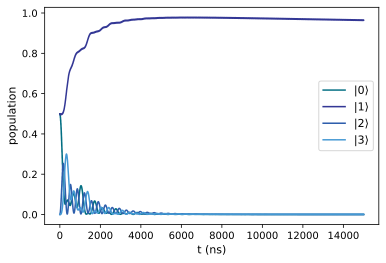

In [33]:
for i in range(4):
    plt.plot(tlist, result.expect[i], label=r"$|%u\rangle$"%(i))
plt.legend()
plt.xlabel("t (ns)")
plt.ylabel("population")

In [34]:
print("Fidelity:", result.expect[1][-1])

Fidelity: 0.9640952961953926
